#Import

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras.models import Sequential, Model
import math
import pickle 
import seaborn as sns
import re
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.cm as cm
import time

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/MyDrive"

Mounted at /content/gdrive


In [ ]:
dataset = os.path.join(root_dir, "SigNature/Datasets/SigNature_integration_HQ_augmented_2")
pickle_path = dataset + "/SigNature_integr_HQ_augmented_fine_tuning.pickle"

Dataset is imported this way: x_train, x_val, x_test contain images, y_01 contain Forged/Genuine labels, while y_id contain ids of the relative user.



In [ ]:
x_train, y_01_train, y_id_train = [], [], []
x_test, y_01_test, y_id_test = [], [], []
x_val, y_01_val, y_id_val = [], [], []

This is the function to load the dataset from scratch, and to save the pickle file to the relative path

In [ ]:
def load_slow():
  data_dir = os.path.join(dataset, "Train")
  data_dir_test = os.path.join(dataset, "Test")

  content = os.listdir(data_dir)
  n = len(content) // 2
  n_train = int(n * 0.8)

  for folder in tqdm(os.listdir(data_dir)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir, folder)
    n_imgs = len(os.listdir(path))
    n_val = n_imgs - 5
    #n_val = math.ceil(0.1 * n_imgs)
    
    if user_id >= n_train:
      for i in range(n_val):
        img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_val.append(img_obj)
        y_01_val.append(is_genuine)
        y_id_val.append(user_id)
      for i in range(n_val, n_imgs):
        img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_train.append(img_obj)
        y_01_train.append(is_genuine)
        y_id_train.append(user_id)
    
  for folder in tqdm(os.listdir(data_dir_test)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir_test, folder)
  
    if user_id >= n_train:
      for img in os.listdir(path):
        img_path = os.path.join(data_dir_test, folder, img)
        img_obj = cv2.imread(img_path, 0)
        img_obj = np.array(img_obj).astype("float32") / 255
        x_test.append(img_obj)
        y_01_test.append(is_genuine)
        y_id_test.append(user_id)

  f = open(pickle_path, "wb") 
  pickle.dump([(x_train, y_01_train, y_id_train),
               (x_test, y_01_test, y_id_test),
               (x_val, y_01_val, y_id_val)], f)
  f.close()

This is the function to load the dataset from the pickle file

In [ ]:
def load_fast():
  data_dir = os.path.join(dataset, "Train")
  content = os.listdir(data_dir)
  n = len(content) // 2
  n_train = int(n * 0.8)

  print(len(x_train) / (n - n_train + 1))
  f = open(pickle_path, "rb") 
  train_set, test_set, val_set = pickle.load(f)
  f.close()
  return train_set, test_set, val_set

If we find the pickle file, we load it. Otherwise we load the dataset from scratch.

In [ ]:
if os.path.isfile(pickle_path) and False: 
  train_set, test_set, val_set = load_fast()
  x_train, y_01_train, y_id_train = train_set
  x_test, y_01_test, y_id_test = test_set
  x_val, y_01_val, y_id_val = val_set
else: 
  load_slow()

100%|██████████| 218/218 [00:51<00:00,  4.22it/s]


## Preparing the data
---



Only 2 classes are needed: forged and genuine

In [ ]:
num_classes = 2

One hot encoding of the classes

In [ ]:
y_01_test = keras.utils.to_categorical(y_01_test, num_classes)
y_01_train = keras.utils.to_categorical(y_01_train, num_classes)
y_01_val = keras.utils.to_categorical(y_01_val, num_classes)

Espand dimensions for the CNN model input, the new correct shape is:
 128 x 256 x 1



In [ ]:
x_test = np.expand_dims(x_test, -1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)

input_shape = (128, 256, 1)

Shuffle randomly the dataset to not bias the model in training phase

In [ ]:
x_train, y_01_train, y_id_train = shuffle(x_train, y_01_train, y_id_train)
x_test, y_01_test, y_id_test = shuffle(x_test, y_01_test, y_id_test)
x_val, y_01_val, y_id_val = shuffle(x_val, y_01_val, y_id_val)

#Fine tuning model

Here we define some functions to calculate the f1_m during the training.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
fbasicmodel = dataset + '/basic_model.h5'
dependencies = {
    'f1_m': f1_m
}

###Split by Id

Here we split the train, validation and test sets for each user id, in order to train a diffrent model for each of them

In [ ]:
data_dir = os.path.join(dataset, "Train")

content = os.listdir(data_dir)
n = len(content) // 2
n_train = int(n * 0.8)

In [ ]:
tailored_grouped_by_id_train = {}
for i in range(len(x_train)):
  if not y_id_train[i] in tailored_grouped_by_id_train:
    tailored_grouped_by_id_train[y_id_train[i]] = [[],[],[]]
  tailored_grouped_by_id_train[y_id_train[i]][0].append(x_train[i])
  tailored_grouped_by_id_train[y_id_train[i]][1].append(y_01_train[i])
  tailored_grouped_by_id_train[y_id_train[i]][2].append(y_id_train[i])


In [ ]:
tailored_grouped_by_id_val = {}
for i in range(len(x_val)):
  if not y_id_val[i] in tailored_grouped_by_id_val:
    tailored_grouped_by_id_val[y_id_val[i]] = [[],[],[]]
  tailored_grouped_by_id_val[y_id_val[i]][0].append(x_val[i])
  tailored_grouped_by_id_val[y_id_val[i]][1].append(y_01_val[i])
  tailored_grouped_by_id_val[y_id_val[i]][2].append(y_id_val[i])

In [ ]:
tailored_grouped_by_id_test = {}
for i in range(len(x_test)):
  if not y_id_test[i] in tailored_grouped_by_id_test:
    tailored_grouped_by_id_test[y_id_test[i]] = [[],[],[]]
  tailored_grouped_by_id_test[y_id_test[i]][0].append(x_test[i])
  tailored_grouped_by_id_test[y_id_test[i]][1].append(y_01_test[i])
  tailored_grouped_by_id_test[y_id_test[i]][2].append(y_id_test[i])

In [ ]:
for id in range(n_train, n+1):
  tailored_grouped_by_id_train[id][0] = np.array(tailored_grouped_by_id_train[id][0])
  tailored_grouped_by_id_val[id][0] = np.array(tailored_grouped_by_id_val[id][0])
  tailored_grouped_by_id_test[id][0] = np.array(tailored_grouped_by_id_test[id][0])

In [ ]:
for id in range(n_train, n+1):
  tailored_grouped_by_id_train[id][1] = np.array(tailored_grouped_by_id_train[id][1])
  tailored_grouped_by_id_val[id][1] = np.array(tailored_grouped_by_id_val[id][1])
  tailored_grouped_by_id_test[id][1] = np.array(tailored_grouped_by_id_test[id][1])

In [ ]:
for id in range(n_train, n+1):
  tailored_grouped_by_id_train[id][2] = np.array(tailored_grouped_by_id_train[id][2])
  tailored_grouped_by_id_val[id][2] = np.array(tailored_grouped_by_id_val[id][2])
  tailored_grouped_by_id_test[id][2] = np.array(tailored_grouped_by_id_test[id][2])

###Training - Models

We initialize a new model for each user, loading the basic model

In [ ]:
models_1 = {}
for id in range(n_train, n+1):
  models_1[id] = keras.models.load_model(fbasicmodel, custom_objects=dependencies)

In [ ]:
models_1[n_train].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 30, 128)      0

We train each user for 500 epochs. We use a very high number of epochs because we want to understand if it is possibile to generate a model that does not overfit on the long run, so that we can train it as long as we can, hoping to improve generalization performances thanks to the dropout regularization.

In [ ]:
n_epochs1 = 500
batch_size1 = 8
network_history1 = {}

for id in range(n_train, n+1):
  network_history1[id] = models_1[id].fit(tailored_grouped_by_id_train[id][0], tailored_grouped_by_id_train[id][1], batch_size=batch_size1, epochs=n_epochs1, verbose=2, validation_data=(tailored_grouped_by_id_val[id][0], tailored_grouped_by_id_val[id][1]))

Output streaming troncato alle ultime 5000 righe.
Epoch 1/500
2/2 - 1s - loss: 1.5807 - accuracy: 0.7000 - f1_m: 0.4375 - val_loss: 0.2794 - val_accuracy: 0.9182 - val_f1_m: 0.9167 - 1s/epoch - 619ms/step
Epoch 2/500
2/2 - 0s - loss: 0.7324 - accuracy: 0.8000 - f1_m: 0.4667 - val_loss: 0.7392 - val_accuracy: 0.8636 - val_f1_m: 0.8601 - 388ms/epoch - 194ms/step
Epoch 3/500
2/2 - 0s - loss: 0.0625 - accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 1.2126 - val_accuracy: 0.8182 - val_f1_m: 0.8185 - 259ms/epoch - 130ms/step
Epoch 4/500
2/2 - 0s - loss: 0.2602 - accuracy: 0.8000 - f1_m: 0.9118 - val_loss: 1.5864 - val_accuracy: 0.7909 - val_f1_m: 0.7893 - 380ms/epoch - 190ms/step
Epoch 5/500
2/2 - 0s - loss: 0.5903 - accuracy: 0.9000 - f1_m: 0.9375 - val_loss: 1.3368 - val_accuracy: 0.8091 - val_f1_m: 0.8095 - 227ms/epoch - 114ms/step
Epoch 6/500
2/2 - 0s - loss: 0.0444 - accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.9330 - val_accuracy: 0.8455 - val_f1_m: 0.8452 - 226ms/epoch - 113ms/step
Epoch

## Analyze and comment training results

We will show the training results for a subset of users

User 87


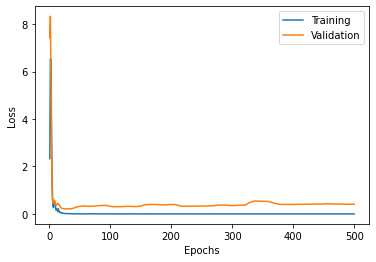

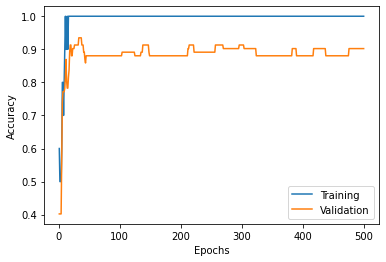

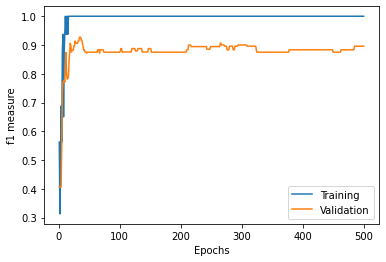

User 88


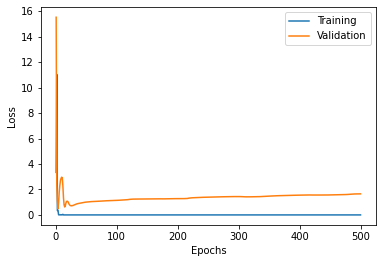

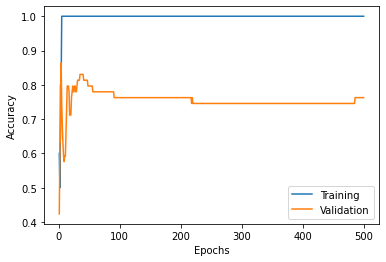

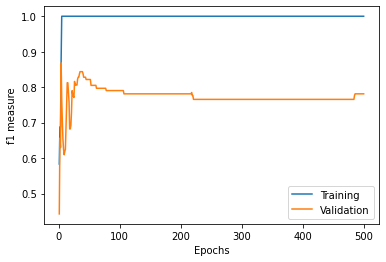

User 89


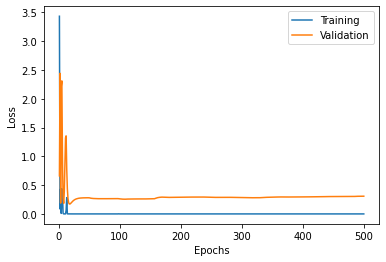

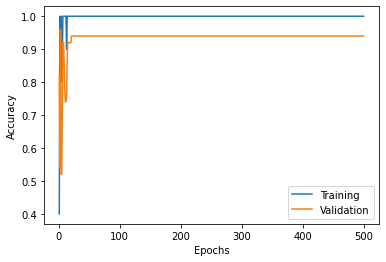

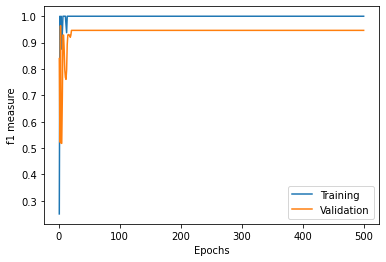

User 90


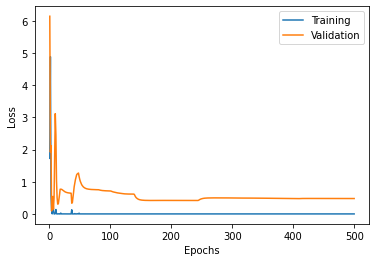

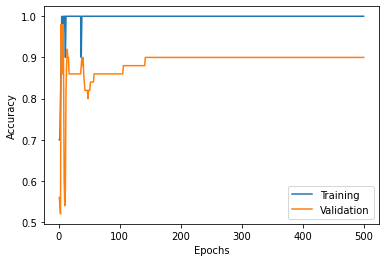

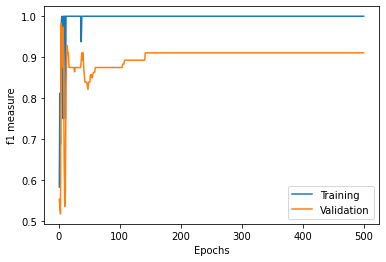

In [ ]:
x_plot = list(range(1,n_epochs1 +1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history['loss'])
    plt.plot(x_plot, network_history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history['accuracy'])
    plt.plot(x_plot, network_history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('f1 measure')
    plt.plot(x_plot, network_history['f1_m'])
    plt.plot(x_plot, network_history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

for id in range(87, 91):
  print("User " + str(id))
  plot_history(network_history1[id].history)

###Comments

As we can see the performances on the validation set is what we aimed to obtain, since, even training for a long run. This is due to the dropout that forces the network.

## Predictions on test set

In [ ]:
for id in range(n_train, n+1):
  score = models_1[id].evaluate(tailored_grouped_by_id_test[id][0], tailored_grouped_by_id_test[id][1], verbose=0)
  print("Id ", id)
  print("Test loss", score[0])
  print("Test accuracy", score[1])

Id  87
Test loss 0.18514010310173035
Test accuracy 0.8571428656578064
Id  88
Test loss 0.088454470038414
Test accuracy 1.0
Id  89
Test loss 0.011027193628251553
Test accuracy 1.0
Id  90
Test loss 0.026371005922555923
Test accuracy 1.0
Id  91
Test loss 1.0821354389190674
Test accuracy 0.699999988079071
Id  92
Test loss 0.8681078553199768
Test accuracy 0.875
Id  93
Test loss 2.249704360961914
Test accuracy 0.75
Id  94
Test loss 4.9498291015625
Test accuracy 0.5
Id  95
Test loss 0.010689781978726387
Test accuracy 1.0
Id  96
Test loss 6.010900497436523
Test accuracy 0.5
Id  97
Test loss 0.0004262383736204356
Test accuracy 1.0
Id  98
Test loss 0.024663308635354042
Test accuracy 1.0
Id  99
Test loss 2.204087734222412
Test accuracy 0.6000000238418579
Id  100
Test loss 0.1567285805940628
Test accuracy 1.0
Id  101
Test loss 6.124832907516975e-07
Test accuracy 1.0
Id  102
Test loss 3.028708670171909e-05
Test accuracy 1.0
Id  103
Test loss 1.7771241664886475
Test accuracy 0.875
Id  104
Test loss 

In [ ]:
predictions = {}
for id in range(n_train, n+1):
  predictions[id] = np.argmax(models_1[id].predict(tailored_grouped_by_id_test[id][0]), axis=1) 
  predictions[id] = keras.utils.to_categorical(predictions[id], num_classes)

Here we show the classification reports for each user.

In [ ]:
from sklearn.metrics import classification_report

for id in range(n_train, n+1):
  print(classification_report(predictions[id], tailored_grouped_by_id_test[id][1]))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.75      1.00      0.86         3

   micro avg       0.86      0.86      0.86         7
   macro avg       0.88      0.88      0.86         7
weighted avg       0.89      0.86      0.86         7
 samples avg       0.86      0.86      0.86         7

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5
 samples avg       1.00      1.00      1.00         5

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         4
   macro avg       1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [ ]:
predictions_tot = predictions[n_train]

for id in range(n_train+1, n+1):
  predictions_tot = np.concatenate((predictions_tot, predictions[id]))

In [ ]:
real_labels_tot = tailored_grouped_by_id_test[n_train][1]

for id in range(n_train+1, n+1):
  real_labels_tot = np.concatenate((real_labels_tot, tailored_grouped_by_id_test[id][1]))

In [ ]:
print(classification_report(predictions_tot, real_labels_tot, digits=6))

              precision    recall  f1-score   support

           0   0.894737  0.809524  0.850000        84
           1   0.783784  0.878788  0.828571        66

   micro avg   0.840000  0.840000  0.840000       150
   macro avg   0.839260  0.844156  0.839286       150
weighted avg   0.845917  0.840000  0.840571       150
 samples avg   0.840000  0.840000  0.840000       150



## Predictions by user id


In this section is described , for each user, the performance evaluation.
 This is done mainly to undersand who are the users that performs better and worst.

In [ ]:
users_score = []

n = len(os.listdir(dataset + "/Test")) // 2
for i in tqdm(range(n_train, n + 1)):
  x_user = []
  y_user = []

  folder_g = str(i) + "_genuine"
  folder_f = str(i) + "_forged"
  
  for img in os.listdir(dataset + "/Test" + "/" + folder_g):
    path = os.path.join(dataset, "Test", folder_g, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user.append(img_obj)
    y_user.append(1)

  for img in os.listdir(dataset + "/Test" + "/" + folder_f):
    path = os.path.join(dataset, "Test", folder_f, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user.append(img_obj)
    y_user.append(0)

  y_user = keras.utils.to_categorical(y_user, num_classes)
  x_user = np.expand_dims(x_user, -1)
  score = models_1[i].evaluate(x_user, y_user, verbose=0)

  predictions = np.argmax(models_1[i].predict(x_user), axis=1)
  predictions = keras.utils.to_categorical(predictions, num_classes)
  users_score.append((score, classification_report(predictions, y_user, zero_division=0)))

100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


In [ ]:
labels = [ str(i+n_train) for i in range(0, n - n_train)]

users_acc = [users_score[i][0][1] for i in range(0, n - n_train)]
users_f1 = [users_score[i][0][2] for i in range(0, n - n_train)]

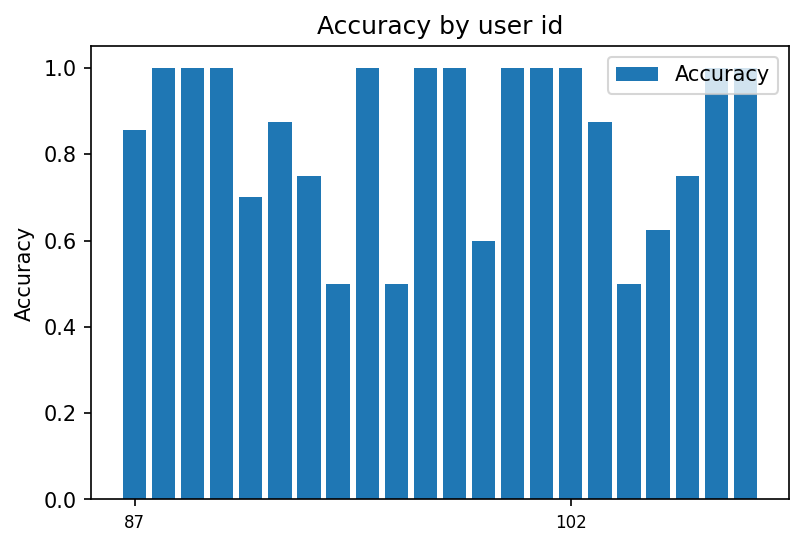

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
ax.bar(labels, users_acc, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by user id')
ax.legend()
fig.set_dpi(150)
plt.xticks(fontsize=8)
ax.set_xticks(np.arange(0, n - n_train, 15))
plt.figure()
plt.show()

In [ ]:
print("Max accuracy:", max(users_acc), "by the user", n_train+users_acc.index(max(users_acc))+1)
print("Min accuracy:", min(users_acc), "by the user", n_train+users_acc.index(min(users_acc))+1)

Max accuracy: 1.0 by the user 89
Min accuracy: 0.5 by the user 95


#Graph measures based on istances number

Here we plot the f1-score, with increasing number of training instances for the single user. The result is obtained by the sum of the prediction for each user

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


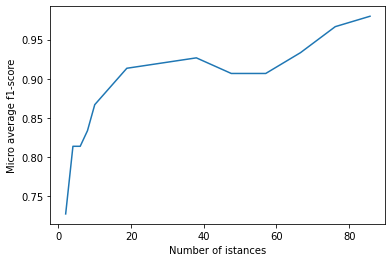

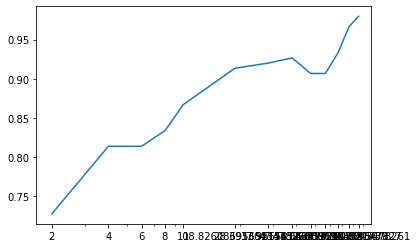

In [ ]:
x = [2, 4, 6, 8, 10, 18.82608695652174, 28.391304347826086, 37.95652173913044, 47.56521739130435, 57.04347826086956, 66.6086956521739, 76.17391304347827, 85.73913043478261]
y = [0.726667, 0.813333, 0.813333, 0.833333, 0.866667, 0.913333, 0.920000, 0.926667, 0.906667, 0.906667, 0.933333, 0.966667, 0.980000]
plt.plot(x,y)

plt.xlabel('Number of istances')
plt.ylabel('Micro average f1-score')

f,ax = plt.subplots()
ax.plot(x,y)
ax.set_xscale('log')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlim([0,100])

plt.show()